In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Download Food-5k dataset

https://www.kaggle.com/binhminhs10/food5k/downloads/food5k.zip

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Settings

In [ ]:
DATASET_PATH = '/content/gdrive/My Drive/Datasets/Food-5K/'

In [6]:
!ls "$DATASET_PATH"

evaluation  training  validation


In [ ]:
training_dir = DATASET_PATH + 'training'
valid_dir = DATASET_PATH + 'validation'
test_dir = DATASET_PATH + 'evaluation'

img_width, img_height = 256, 256
batch_size = 32
epochs = 50

## Data Generators

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
                        training_dir,
                        target_size = (img_height, img_width),
                        batch_size = batch_size, 
                        class_mode = 'binary')

valid_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

valid_generator = valid_datagen.flow_from_directory(
                        valid_dir,
                        target_size = (img_height, img_width),
                        batch_size = batch_size, 
                        class_mode = 'binary')

test_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

test_generator = valid_datagen.flow_from_directory(
                        test_dir,
                        target_size = (img_height, img_width),
                        batch_size = 16, 
                        class_mode = 'binary')

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Image samples

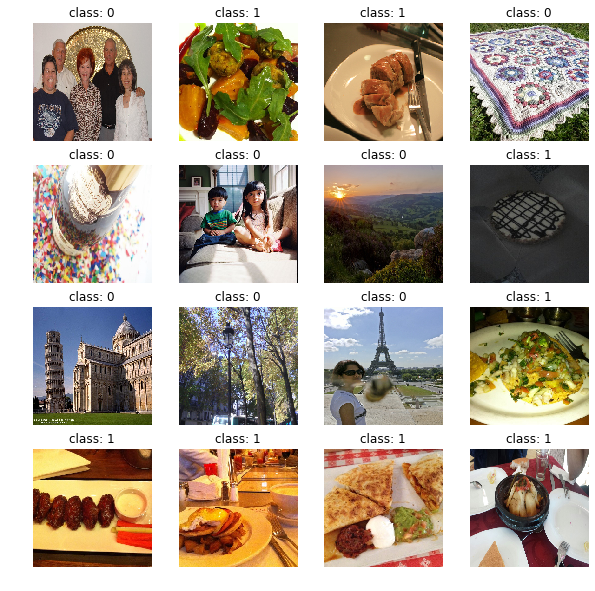

In [9]:
imgs, labels = next(test_generator)
num_figs = 16

fig, axs = plt.subplots(num_figs // 4, 4, figsize=(10,10))
for i in range(num_figs):
    axs[i // 4, i % 4].imshow(imgs[i])
    axs[i // 4, i % 4].axis('off')
    axs[i // 4, i % 4].set_title(f'class: {int(labels[i])}')

## Load VGG model

In [10]:
model = applications.VGG16(weights = "imagenet",
                           include_top = False,
                           input_shape = (img_width, img_height, 3))

model.summary()

W0904 23:02:40.818985 140155137501056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 23:02:40.868875 140155137501056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 23:02:40.880421 140155137501056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 23:02:40.930761 140155137501056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 16s 0us/step


W0904 23:02:57.742197 140155137501056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0904 23:02:57.743899 140155137501056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

## Freeze layers

In [ ]:
for layer in model.layers:
    layer.trainable = False

## Add custom layers

In [12]:
x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

W0904 23:03:10.234012 140155137501056 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
# creating the final model 
model_final = Model(inputs = model.input, outputs = output)

# compile the model 
model_final.compile(loss = "binary_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"])

model_final.summary()

W0904 23:03:10.804991 140155137501056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0904 23:03:10.819249 140155137501056 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

## Model Fit

In [14]:
# Save the model according to the conditions  
checkpoint_file = "vgg16_1.h5"

checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_acc', verbose=1, save_best_only=True,
                             save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')


# Train the model 
hist = model_final.fit_generator(train_generator,
                        steps_per_epoch = train_generator.n // batch_size,
                        epochs = epochs,
                        validation_data = valid_generator,
                        validation_steps = valid_generator.n // batch_size,
                        callbacks = [checkpoint, early],
                        verbose = 1)

Epoch 1/50
93/93 [==============================] - 1137s 12s/step - loss: 0.5205 - acc: 0.7397 - val_loss: 0.3063 - val_acc: 0.9244

Epoch 00001: val_acc improved from -inf to 0.92440, saving model to vgg16_1.h5
Epoch 2/50
93/93 [==============================] - 46s 495ms/step - loss: 0.3186 - acc: 0.8781 - val_loss: 0.2388 - val_acc: 0.9318

Epoch 00002: val_acc improved from 0.92440 to 0.93182, saving model to vgg16_1.h5
Epoch 3/50
93/93 [==============================] - 45s 479ms/step - loss: 0.2533 - acc: 0.9084 - val_loss: 0.2046 - val_acc: 0.9442

Epoch 00003: val_acc improved from 0.93182 to 0.94421, saving model to vgg16_1.h5
Epoch 4/50
93/93 [==============================] - 45s 479ms/step - loss: 0.2359 - acc: 0.9206 - val_loss: 0.1924 - val_acc: 0.9401

Epoch 00004: val_acc did not improve from 0.94421
Epoch 5/50
93/93 [==============================] - 45s 479ms/step - loss: 0.2196 - acc: 0.9257 - val_loss: 0.1626 - val_acc: 0.9494

Epoch 00005: val_acc improved from 0.

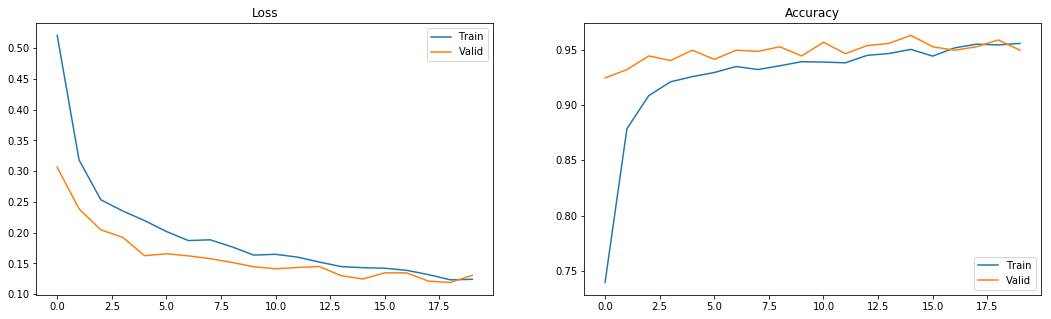

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(18,5))

axs[0].plot(hist.history['loss'], label='Train')
axs[0].plot(hist.history['val_loss'], label='Valid')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(hist.history['acc'], label='Train')
axs[1].plot(hist.history['val_acc'], label='Valid')
axs[1].set_title('Accuracy')
axs[1].legend()
fig.show()

In [43]:
model_final.load_weights(checkpoint_file)

loss, acc = model_final.evaluate_generator(test_generator, steps = test_generator.n // test_generator.batch_size)
print(f'Test Acc: {acc}')

Test Acc: 0.9465725806451613
